<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA_LDA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA with LDA preprocessing
### Notes:

### 0.81.x

#### **Implementing *LDA* algorithm in the preprocessing step based on Zhang and Nakaoka (2024, PLOS One).**

The Latent Dirichlet Allocation (LDA) model enables energy landscape analysis (ELA) to be performed in terms of microbiome assemblages, providing a more coarse-grained view of community state transitions.


## Setup

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'rELA'...
remote: Enumerating objects: 1076, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1076 (delta 357), reused 304 (delta 304), pack-reused 703 (from 1)
Receiving objects: 100% (1076/1076), 11.85 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (532/532), done.


In [ ]:
%%shell
# for topicmodels
sudo apt install gsl-bin libgsl-dbg libgsl-dev libgslcblas0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gsl-bin is already the newest version (2.7.1+dfsg-3).
libgsl-dbg is already the newest version (2.7.1+dfsg-3).
libgsl-dev is already the newest version (2.7.1+dfsg-3).
libgslcblas0 is already the newest version (2.7.1+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
install.packages("devtools")

library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('dplyr')
library('tidyr')
library('ggplot2')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")
library("devtools")

In [ ]:
%%R
# for LDA
install.packages(c("topicmodels", "Matrix", "glmnet", "quanteda"))

In [ ]:
%%R
# for LDA
library("topicmodels")
library("Matrix")
library("stats")
#library("stm")
library("quanteda")

In [ ]:
%%R
# If already installed
detach("package:rELA",unload=TRUE)
remove.packages("rELA")

In [ ]:
%%R
install.packages("rELA/rELA.v0.81.tar.gz")
library("rELA")

### Using randomly generated parameter sets

In [ ]:
%%R
# create dummy data by Dirichlet-Multinominal distribution
# Usage: RandDirichletSet(nspecies, nbasins, nsamples, n_reads=n_reads)

# randDCmat : abndance matrix based on the DM distribution
# prob_vec : probability vector of dirichlet distribution
# vec_idx : indices (indicating category number which each sample belongs to)
list[randDCmat,prob_vec,vec_idx] <- RandDirichletSet(32, 7, 512, n_reads=10000)

[1] 512  32


In [ ]:
%%R
head(randDCmat)

         species.1 species.2 species.3 species.4 species.5 species.6 species.7
sample.1       246       327        99       319       121       113       573
sample.2       220       282       109       338       119       135       589
sample.3       262       299       129       319       131        95       521
sample.4       231       340       113       361       102       118       575
sample.5       257       306       109       380       120        98       539
sample.6       258       299       114       345       112        97       574
         species.8 species.9 species.10 species.11 species.12 species.13
sample.1       119        65        147        216         70        207
sample.2       112        77        167        254         69        229
sample.3       124        84        149        220         89        182
sample.4       123        83        158        251         84        236
sample.5       106        73        161        212         71        207
sample.6 

### run LDA

In [ ]:
%%R
#'lda_for_ela
#'@description Run LDA using optimal assemblage numbers (K)
#'
#'@param abtable (randDCmat, here) : taxa abundance data (without binarization)
#'@param M: multiplied factors for converting to interger matrix
#'@param K_grid : array of Ks used for searching optimal clusters (K)
#'@param K_fixed: (integer) used for stm.if NULL, optimal K will be searched using K_grid.
#'@param seed : the random seed for clustering.
#'@param train_idx : indices used for training.
#'@param Normalize : (bool) If true, the data will be normalized so that the sum of each row is 1.
#'@returns k_opt : used K for lda
#'@returns theta : sample-assemblage matrix
#'@returns beta : assemblage-taxa matrix)
#'----

list[k_summary,lda_mat,lda_beta] <- lda_for_ela(randDCmat, M=1000, K_grid = 5:10,
                                                 K_fixed = NULL,seed = 123,train_idx = NULL,
                                                 Normalize=TRUE)

[1] "LDA finished."


In [ ]:
%%R
# showing summary for K search
k_summary

   K   logLik perplexity
5  9 -1565795   21.29187
6 10 -1566117   21.30525
4  8 -1569852   21.46124
3  7 -1571232   21.51918
1  5 -1575042   21.67992
2  6 -1575653   21.70580


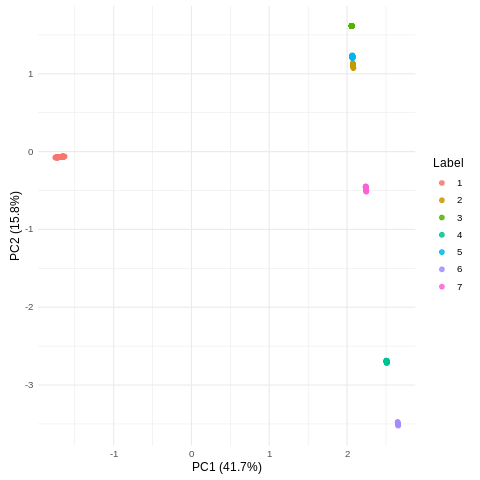

In [ ]:
%%R
# We verify whether samples with similar transformed composition after performing LDA
# on an abundance matrix generated by a Dirichlet multinominal distribution
# share the same label (species distribution) in the original Dirichlet distribution.

# We perform PCA on the matrix after applying LDA and plot the sample composition on two-dimension.
# We then confirm whether the observed clusters in PCA match the labels in the original distribution.

# PCA
p <- prcomp(lda_mat, center = TRUE, scale. = TRUE)
scores <- as.data.frame(p$x[, 1:2])
var_exp <- (p$sdev^2) / sum(p$sdev^2)
scores$label <- factor(vec_idx) # labeling
ggplot(scores, aes(x = PC1, y = PC2, color = label)) + # PC plot
  geom_point(size = 2, alpha = 0.85) +
  coord_equal() +
  labs(
    x = sprintf("PC1 (%.1f%%)", 100 * var_exp[1]),
    y = sprintf("PC2 (%.1f%%)", 100 * var_exp[2]),
    color = "Label"
  ) +
  theme_minimal(base_size = 12)

## run ELA using cluster-based matrix (LDA)


In [ ]:
%%R
head(lda_mat)

                 1            2         3            4         5            6
sample.1 0.3070371 3.418445e-05 0.2564559 3.418445e-05 0.4363019 3.418445e-05
sample.2 0.3201060 3.415024e-05 0.2647488 3.415024e-05 0.4149403 3.415024e-05
sample.3 0.3288916 3.404803e-05 0.2611979 3.404803e-05 0.4097062 3.404803e-05
sample.4 0.2863457 3.411610e-05 0.2924276 3.411610e-05 0.4210220 3.411610e-05
sample.5 0.3128472 3.404803e-05 0.2583006 3.404803e-05 0.4286479 3.404803e-05
sample.6 0.3430909 3.404803e-05 0.2578053 3.404803e-05 0.3988995 3.404803e-05
                    7            8            9
sample.1 3.418445e-05 3.418445e-05 3.418445e-05
sample.2 3.415024e-05 3.415024e-05 3.415024e-05
sample.3 3.404803e-05 3.404803e-05 3.404803e-05
sample.4 3.411610e-05 3.411610e-05 3.411610e-05
sample.5 3.404803e-05 3.404803e-05 3.404803e-05
sample.6 3.404803e-05 3.404803e-05 3.404803e-05


In [ ]:
%%R
# run parameter fitting
list[ocvecs, abvecs, envecs, samplelabel, specieslabel, factorlabel] <- Formatting(lda_mat, NULL, 0, c(0.01, 0.01, 0.99))
list[bp,allresults] <- Findbp(ocvecs,enmat=NULL,rep=32,threads=2,ssize = 0.5,
                              fastfitting = TRUE,intv=100,runadamW=TRUE,sparse=TRUE,
                              lmd = c(5e-05,0.001,0.005,0.01),
                              totalit=3000,maxlr=0.2)


Processed 512 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
Selected  9  out of  9 species.
Try: lambda=0.000050, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.001000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.005000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.010000, we=0.001000, runadamW=TRUE, Sparse=TRUE



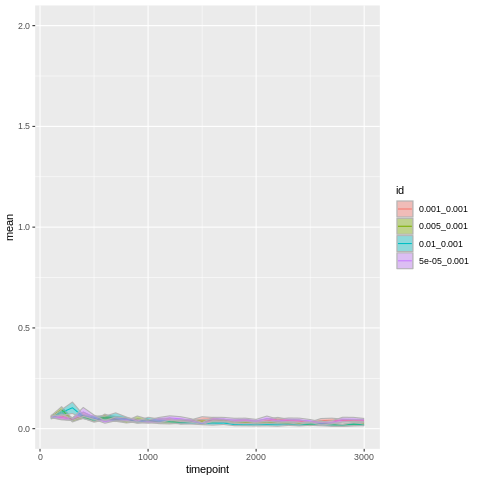

In [ ]:
%%R
plotSAtest(allresults,ylim=c(0,2))

In [ ]:
%%R
list[lmd,we,totalit] <- as.numeric(unlist(strsplit(names(bp)[1], split = "_")))
sa <- runSA(ocvecs, enmat=NULL, rep = 64,threads=2,
            getall=FALSE, totalit=totalit,
            lambda = lmd, we = we, maxlr = 0.2)

list[he,je,ge,envecs] <- sa2params(sa)


Start parameter fitting:
SA: elapsed time 40.28 sec



### Running ELA.

In [ ]:
%%R
ela <- ELA(sa, env=NULL,
           SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
           threads=2, reporting=TRUE)

elap <- ELPruning(ela, th=0.1)

Start ELA:
6 stable states were found.
Checking 15 tipping points.
converting...
ELA: elapsed time 0.63 sec
Start pruning:
*.
ELPruning: elapsed time 0.08 sec


NULL


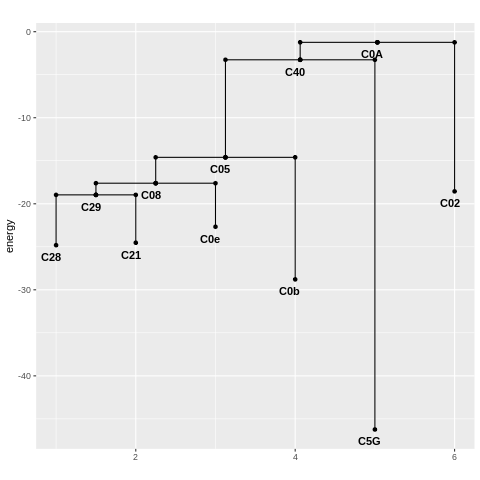

In [ ]:
%%R
# show DG Graph
showDG(ela, lda_mat)

### Extact key species involving transition between 2 stable states from assemlage matrix.

In [ ]:
%%R
nclusters <- 9
target1 <- "5G"
target2 <- "0b"
# "C0b" -> "C5G"
transition_1 <- t(lda_beta) %*%　id2bin(target1,nclusters) - t(lda_beta) %*%　id2bin(target2,nclusters)
transition_1 <- transition_1[order(transition_1, decreasing = TRUE), ]
transition_1

In [ ]:
%%R
# opposite case to the above example
# "C5G" -> "C0b"
transition_2 <- t(lda_beta) %*% id2bin(target2,nclusters) - t(lda_beta) %*% id2bin(target1,nclusters)
transition_2 <- transition_2[order(transition_2, decreasing = TRUE), ]
transition_2